# Channel Model

This notebook is used to create Channel Model for mmWave base on extended Saleh-Valenzuela model, which allows us to accurately capture the mathematical structure present in mmWave channels.
Most content is base on the paper:

O. El Ayach, S. Rajagopal, S. Abu-Surra, Z. Pi, and R. Heath, “Spatially sparse precoding in millimeter wave MIMO systems,” IEEE Transactions on WirelessCommunications, vol. 13, no. 3, pp. 1499–1513, March 2014

and Matlab Sourcode from repository https://github.com/xyuam/Alternating-minimization-algorithms-for-hybrid-precoding-in-millimeter-wave-MIMO-systems

$$H = \sqrt{\frac{N_{t}N_{r}}{N_{cl}N_{ray}}}\sum_{i=1}^{N_{cl}}\sum_{l=1}^{N_{ray}}\alpha_{il}\mathbf{a_{r}}(\phi _{il}^{r},\theta _{il}^{r} )\mathbf{a_{t}}(\phi _{il}^{t},\theta _{il}^{t} )^{H}$$

Where $N_{cl}$ and $N_{ray}$ represent the number of clusters and the number of rays in each cluster, and $\alpha_{il}$ denotes the gain of the $l^{th}$ ray in the $i^{th}$ propagation cluster. We assume that $\alpha_{il}$ are i.i.d and follow the distribution $\mathcal{C}\mathcal{N}(0,\sigma _{\alpha ,i}^{2})$ and $\sum _{i=1}^{N_{cl}}\sigma _{\alpha ,i}^{2} = \hat{\gamma }$, which is the normalization factor to satisfy $\mathbf{E}\left [ \left \| \mathbf{H} \right \|_{F}^{2}\right ] = N_{t}N_{r}$. In addition $\mathbf{a_{r}}(\phi _{il}^{r},\theta _{il}^{r} )$ and $\mathbf{a_{t}}(\phi _{il}^{t},\theta _{il}^{t} )$ represent the receive and transmit array response vectors, where $\phi _{il}^{r}$($\phi _{il}^{t}$) and $\theta _{il}^{r}$($\theta _{il}^{t}$) stand for azimuth and elevation angles of arrival and departure, respectively. We use the uniform square planar array (USPA) with $\sqrt{N}$x$\sqrt{N}$ antenna elements.

In [1]:
# import necessary module 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### Array Response

This function is used to calculate the array response in uniform square planar array (USPA) with given azimuth, elevation angle and number of element
$$\mathbf{a}(\phi _{il},\theta _{il}) = \frac{1}{\sqrt{N}}[1,...,e^{j\frac{2\pi }{\lambda}d(psin\phi _{il}sin\theta _{il}+qcos\theta _{il})},...,e^{j\frac{2\pi }{\lambda}d((\sqrt{N}-1)sin\phi _{il}sin\theta _{il}+(\sqrt{N}-1)cos\theta _{il})}]^{T}$$

In [2]:
def array_response(a1,a2,N):
    y = np.zeros((N,1),dtype=complex)
    for m in range(int(np.sqrt(N))):
        for n in range(int(np.sqrt(N))):
            y[m*(int(np.sqrt(N)))+n] = np.exp(1j*np.pi*(m*np.sin(a1)*np.sin(a2) + n*np.cos(a2)))
    y = y/np.sqrt(N)
    y = np.ravel(y) # Convent to 1-dimention, MAY BE NOT THE BEST WAY
    return y

In [3]:
test = array_response(1,1,4) # Test output of array response
print(test)

[ 0.50000000+0.j         -0.06313770+0.49599761j -0.30405671+0.39692508j
 -0.35535290-0.35174468j]


### Parameters declaration

Declare parameters needed for channel realization

In [4]:
Ns = 3 # number of streams

Nc = 5 # number of cluster
Nray = 10 # number of rays in each cluster

Nt = 144 # number of transmit antennas
Nr = 36 # number of receive antennas

angle_sigma = 10/180*np.pi # standard deviation of the angles in azimuth and elevation both of Rx and Tx

gamma = np.sqrt((Nt*Nr)/(Nc*Nray))
sigma = 1 # according to the normalization condition of H

realization = 1000 # equivalent to number of taking sample
count = 0


### Example of Laplacian Distribution
Using Laplacian distributed for declaration of azimuth and elevation angles of arrival and departure (has been found to be a good fit for a variaty of propagation scenarios)

array([[-0.88444514,  0.03645181,  2.21464581],
       [ 0.44830326,  1.37179992, -0.69282939]])

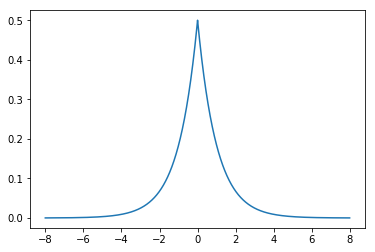

In [5]:
# plot the probability density function (PDF) of Laplacian Distribution
loc, scale = 0., 1.
s = np.random.laplace(loc, scale, 1000)
# count, bins, ignored = plt.hist(s, 30, normed=True)
x = np.arange(-8., 8., .01)
pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)
plt.plot(x, pdf)
# example of create matrix of laplacian variables
y = np.random.laplace(loc, scale, (2,3))
y

### Channel Realization

Create Channel Matrix H and also the optimal Precoder and Combiner (Fopt and Wopt) for MIMO system

In [6]:
H = np.zeros((Nr,Nt,realization),dtype=complex)
At = np.zeros((Nt,Nc*Nray,realization),dtype=complex)
Ar = np.zeros((Nr,Nc*Nray,realization),dtype=complex)
alpha = np.zeros((Nc*Nray,realization),dtype=complex)
Fopt = np.zeros((Nt,Ns,realization),dtype=complex)
Wopt = np.zeros((Nr,Ns,realization),dtype=complex)

AoD = np.zeros((2,Nc*Nray),dtype=complex)
AoA = np.zeros((2,Nc*Nray),dtype=complex)

for reali in range(realization):
    for c in range(1,Nc+1):
        AoD_m = np.random.uniform(0,2*np.pi,2) # Mean Angle of Departure
        AoA_m = np.random.uniform(0,2*np.pi,2) # Mean Angle of Arrival
        AoD[0,(c-1)*Nray:Nray*c] = np.random.laplace(AoD_m[0], angle_sigma, (1,Nray))
        AoD[1,(c-1)*Nray:Nray*c] = np.random.laplace(AoD_m[1], angle_sigma, (1,Nray))
        AoA[0,(c-1)*Nray:Nray*c] = np.random.laplace(AoA_m[0], angle_sigma, (1,Nray))
        AoA[1,(c-1)*Nray:Nray*c] = np.random.laplace(AoA_m[1], angle_sigma, (1,Nray))
    for j in range(Nc*Nray):
        At[:,j,reali] = array_response(AoD[0,j],AoD[1,j],Nt) # UPA array response
        Ar[:,j,reali] = array_response(AoA[0,j],AoA[1,j],Nr)
        alpha[j,reali] = np.random.normal(0, np.sqrt(sigma/2)) + 1j*np.random.normal(0, np.sqrt(sigma/2)) # related to power normalization
        H[:,:,reali] = H[:,:,reali] + alpha[j,reali]*Ar[:,[j],reali]@At[:,[j],reali].conj().T # Review more proper code 
    H[:,:,reali] = gamma * H[:,:,reali]
    if (np.linalg.matrix_rank(H[:,:,reali])>=Ns):
        count = count + 1
        U, s, V = np.linalg.svd(H[:,:,reali], full_matrices=True)
        Fopt[:,:,reali] = V[0:Nt,0:Ns]
        Wopt[:,:,reali] = U[0:Nr,0:Ns]

In [7]:
print(H.shape)
print(Ar.shape)
print(At.shape)
print(Fopt.shape)
print(Wopt.shape)

(36, 144, 1000)
(36, 50, 1000)
(144, 50, 1000)
(144, 3, 1000)
(36, 3, 1000)


**Store Variables to reuse**

In [8]:
%store Ns
%store Nt
%store Nr
%store Nc
%store Nray

%store H
%store Fopt
%store Wopt
%store realization
%store At
%store Ar

Stored 'Ns' (int)
Stored 'Nt' (int)
Stored 'Nr' (int)
Stored 'Nc' (int)
Stored 'Nray' (int)
Stored 'H' (ndarray)
Stored 'Fopt' (ndarray)
Stored 'Wopt' (ndarray)
Stored 'realization' (int)
Stored 'At' (ndarray)
Stored 'Ar' (ndarray)


(36, 144, 1000)


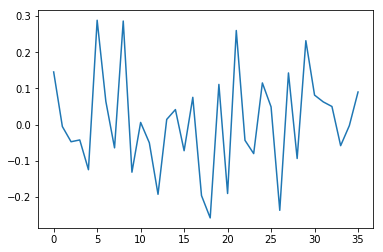

In [9]:
print(H.shape)
plt.plot(Wopt[:,2,1].real)
# np.absolute(1.2 + 1j)
# a = np.array([1+2j, 3+4j, 5+6j])
# a.imag


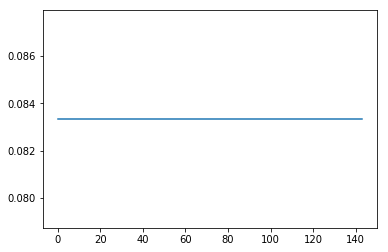

In [10]:
plt.plot(np.absolute(At[:,1,1]))
